In [ ]:
##https://www.tensorflow.org/tutorials/images/classification

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import joblib

%matplotlib inline

Due the size of dataset

In [2]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "../datasets",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5539 files belonging to 12 classes.
Using 4432 files for training.
Using 1107 files for validation.


In [3]:
train_ds
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

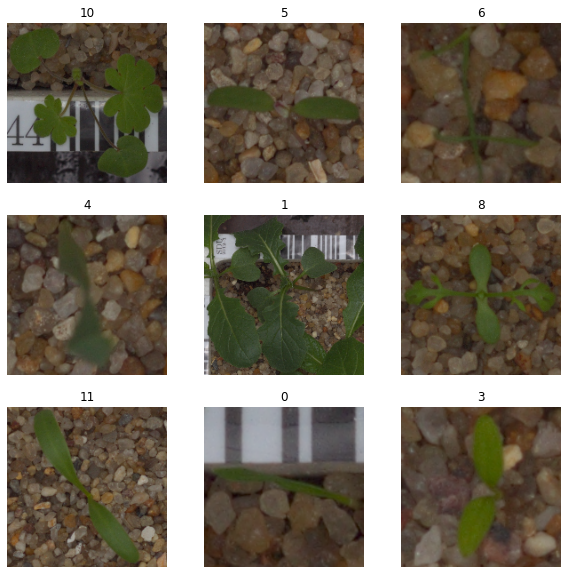

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 180, 180, 3)
(128,)


The image_batch is a tensor of the shape (128, 180, 180, 3). This is a batch of 128 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (128,), these are corresponding labels to the 128 images.

Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data
Here, I will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [7]:
normalization_layer = layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.025620885 0.58253443


## Create the model

In [9]:
num_classes = 12
img_height = 180
img_width = 180

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


35/35 [==============================] - 64s 2s/step - loss: 2.1037 - accuracy: 0.2719 - val_loss: 1.4809 - val_accuracy: 0.5041
Epoch 2/10
35/35 [==============================] - 57s 2s/step - loss: 1.2859 - accuracy: 0.5535 - val_loss: 1.1829 - val_accuracy: 0.6061
Epoch 3/10
35/35 [==============================] - 60s 2s/step - loss: 0.9729 - accuracy: 0.6728 - val_loss: 0.9871 - val_accuracy: 0.6757
Epoch 4/10
35/35 [==============================] - 52s 1s/step - loss: 0.7522 - accuracy: 0.7523 - val_loss: 0.8955 - val_accuracy: 0.7037
Epoch 5/10
35/35 [==============================] - 54s 2s/step - loss: 0.6486 - accuracy: 0.7793 - val_loss: 0.8917 - val_accuracy: 0.7145
Epoch 6/10
35/35 [==============================] - 53s 2s/step - loss: 0.5164 - accuracy: 0.8346 - val_loss: 0.7856 - val_accuracy: 0.7561
Epoch 7/10
35/35 [==============================] - 55s 2s/step - loss: 0.4035 - accuracy: 0.8648 - val_loss: 0.8130 - val_accuracy: 0.7588
Epoch 8/10
35/35 [=============

### Visualize results of training

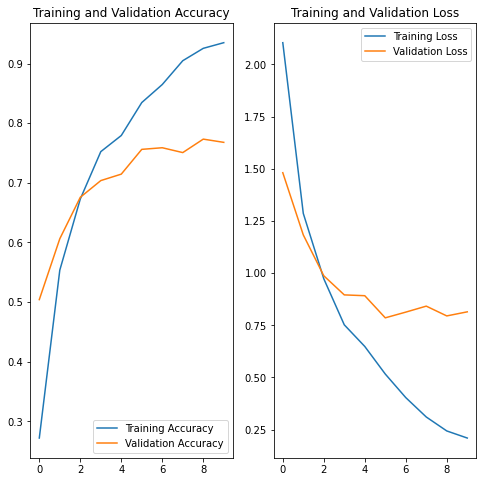

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
### Save the model, before to keep going on
joblib.dump(model, '../model/psc_model.joblib', compress=5)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...layers\rescaling
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json     

['../model/psc_model.joblib']